# Approach

Another way to perform unsupervised clustering is to use ensemble approaches. In this case, I selected a Gradient Boosting Classifier from `sklearn`. Briefly, Gradient Boosting Classifiers work by creating a set of `n` weak learners that can be combined to create a single strong learner. The boosting happens by punishing poorer learners through down-weighting and raising the weights of good learners. It seems unlikely that an ensemble approach will outperform logistic regression by a lot, or maybe even at all, but there are some potential benefits to the ensemble approach. In particular, ensemble classifiers select features differently from logistic regression, so we might get a complimentary view on the important features for classifying `luminal A` and `luminal B` cancers.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.ensemble import GradientBoostingClassifier

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

Load data

In [2]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

Select training set:

In [3]:
train_idx = np.random.choice(normed.T.index.values,
                             size=np.int(np.floor(len(normed.columns) / 3 * 2)),
                             replace=False).tolist()
test_idx = [n for n in normed.T.index if n not in train_idx]

train_exp = normed.T[normed.T.index.isin(train_idx)]
train_labels = meta[meta.ID.isin(train_idx)].cancer 

test_exp = normed.T[normed.T.index.isin(test_idx)]
test_labels = meta[meta.ID.isin(test_idx)].cancer 

# Training the Gradient Boosting Classifier

Train Gradient Boosting Classifier. We will use 200 estimators taught at a learning rate of 0.05, and we will allow subsampling of 75% of the data. Subsampling allows us to perform out of bag estimates to figure out if we are using too few or too many classifiers. It also allows us to perform stochastic gradient boosting, which will lead to additional feature shrinkage, which can lead to better estimates (though at the expense of additional bias). Finally, we limit the maximum number of features that can be selected to $\sqrt{\texttt{genes measured}} \sim \sqrt{6400} \sim 80$. 

In [5]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=.05,
                                 subsample=0.75, max_depth=5,
                                 random_state=1, max_features='sqrt'
                                ).fit(train_exp, train_labels)
print('Out of the box performance is: {0:.2g}'.format(clf.score(test_exp, test_labels)))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test_labels == 'Luminal_A').sum() / len(test_labels)))

Out of the box performance is: 0.87
Fraction of Luminal_A in test set: 0.56


Our classifier performs pretty well, and quite similarly to logistic regression. Let's quickly make sure we haven't used too many estimators by using an out-of-the-bag error estimate.

Out-of-bag estimate is minimized at  182


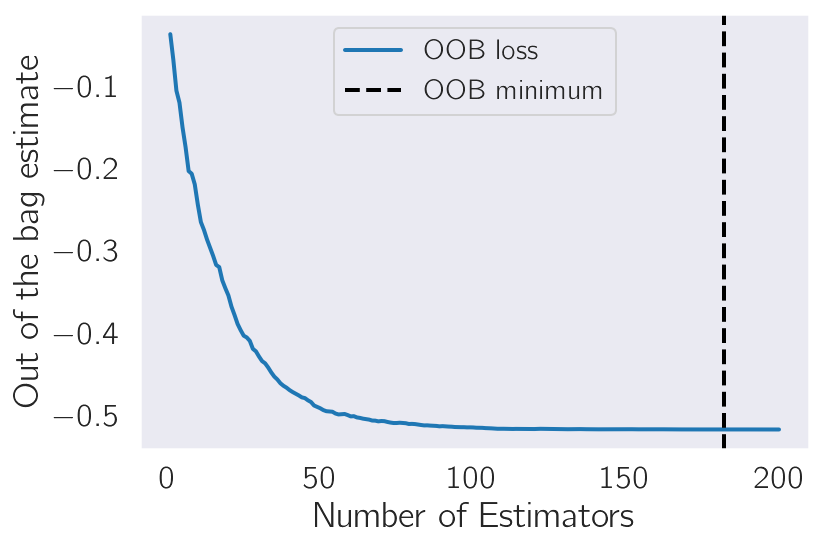

In [6]:
x = np.arange(200) + 1

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]
plt.plot(x, cumsum, label='OOB loss')
plt.axvline(x=oob_best_iter, ls='--', color='black', label='OOB minimum')
plt.xlabel('Number of Estimators')
plt.ylabel('Out of the bag estimate')
plt.legend()
print('Out-of-bag estimate is minimized at ', oob_best_iter)

It looks like we are using too many estimators (the optimal is at the horizontal line), but the function is pretty flat, so let's keep 200. Next, let's look at the histogram of feature importances and verify that the majority of them are 0:

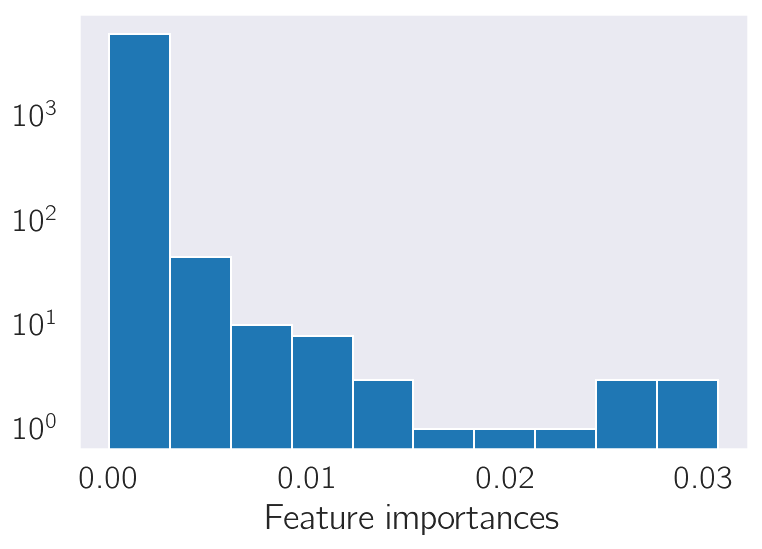

In [7]:
plt.hist(clf.feature_importances_)
plt.yscale('log')
_ = plt.xlabel('Feature importances')

# Extract features

Let's quickly extract features that have a magnitude above 0.005 and look at them

In [8]:
def get_features(data, cond=(clf.feature_importances_ > 0.005)):
    markers = data.index[cond].values
    ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
    ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
    ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
    ens_mark.sort_values("ensembl_gene_id", inplace=True)
    missing = np.array([0 if m not in ensembl.ensembl_gene_id.values else 1 for m in markers ])
    return ens_mark, missing

ens_mark, missing = get_features(df)
ens_mark.head()

,ensembl_gene_id,gene_biotype,external_gene_name,description
61184,ENSG00000134917,protein_coding,ADAMTS8,ADAM metallopeptidase with thrombospondin type...
42569,ENSG00000166592,protein_coding,RRAD,"RRAD, Ras related glycolysis inhibitor and cal..."
58619,ENSG00000169507,protein_coding,SLC38A11,solute carrier family 38 member 11 [Source:HGN...
59140,ENSG00000188610,protein_coding,FAM72B,family with sequence similarity 72 member B [S...
66681,ENSG00000234899,lncRNA,SOX9-AS1,SOX9 antisense RNA 1 [Source:HGNC Symbol;Acc:H...


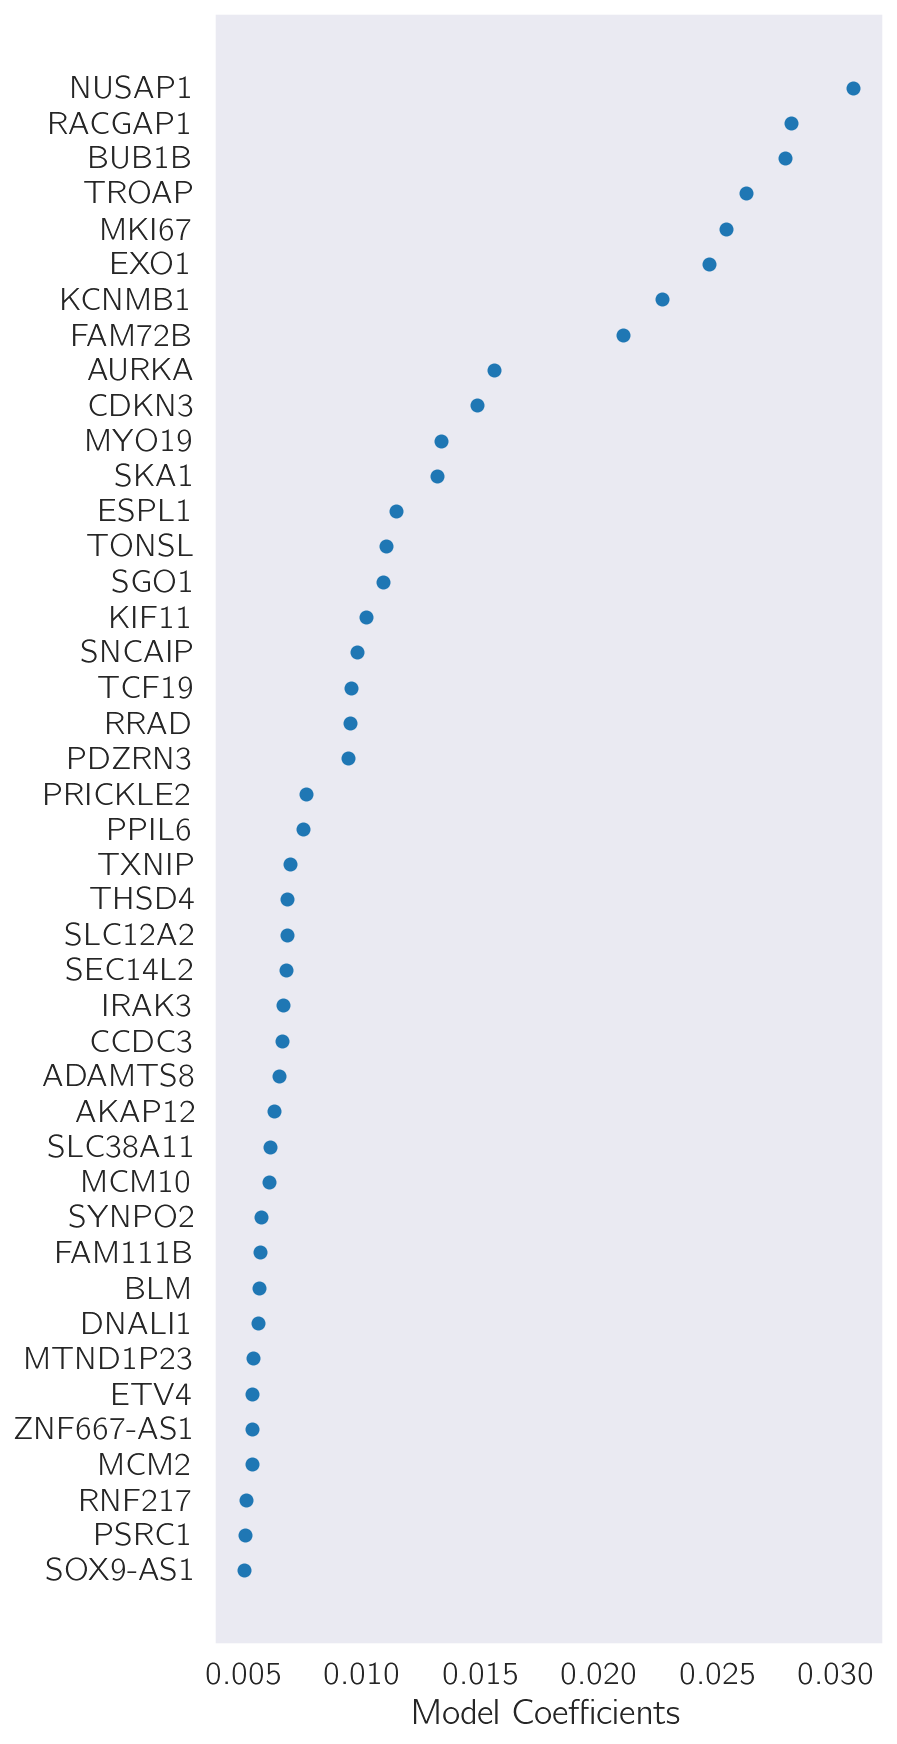

In [9]:
x = clf.feature_importances_[clf.feature_importances_ > 0.005][missing != 0]
sort = np.argsort(x)

fig, ax = plt.subplots(figsize=(6, 15))

plt.plot(x[sort], ens_mark.external_gene_name.values[sort],
         'o')
_ = plt.xlabel('Model Coefficients')

In [10]:
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0051301,cell division,0.000006,True,"""The process resulting in division and partiti...",626,38,12,18092,0.315789,0.019169,query_1,[GO:0009987]
1,GO:CC,GO:0005819,spindle,0.000016,True,"""The array of microtubules and associated mole...",376,40,9,18963,0.225000,0.023936,query_1,"[GO:0015630, GO:0043232]"
2,GO:BP,GO:0140014,mitotic nuclear division,0.000017,True,"""A mitotic cell cycle process comprising the s...",300,38,9,18092,0.236842,0.030000,query_1,"[GO:0000280, GO:1903047]"
3,GO:BP,GO:0000278,mitotic cell cycle,0.000028,True,"""Progression through the phases of the mitotic...",1069,38,14,18092,0.368421,0.013096,query_1,[GO:0007049]
4,GO:BP,GO:1903047,mitotic cell cycle process,0.000045,True,"""A process that is part of the mitotic cell cy...",921,38,13,18092,0.342105,0.014115,query_1,"[GO:0000278, GO:0022402]"
5,GO:CC,GO:0005876,spindle microtubule,0.000072,True,"""Any microtubule that is part of a mitotic or ...",68,40,5,18963,0.125000,0.073529,query_1,"[GO:0005819, GO:0005874]"
6,GO:CC,GO:0072686,mitotic spindle,0.000094,True,"""A spindle that forms as part of mitosis. Mito...",137,40,6,18963,0.150000,0.043796,query_1,[GO:0005819]
7,GO:BP,GO:0048285,organelle fission,0.000108,True,"""The creation of two or more organelles by div...",500,38,10,18092,0.263158,0.020000,query_1,[GO:0006996]
8,GO:BP,GO:0007049,cell cycle,0.000152,True,"""The progression of biochemical and morphologi...",1914,38,17,18092,0.447368,0.008882,query_1,[GO:0009987]
9,REAC,REAC:R-HSA-69620,Cell Cycle Checkpoints,0.000237,True,Cell Cycle Checkpoints,270,22,7,10531,0.318182,0.025926,query_1,[REAC:R-HSA-1640170]


# Identifying stable features

It appears the features the classifier selected are strongly enriched for functions associated with cell division. However, if we re-run this ensemble method, we find that the features that are selected are often quite different. Let's run the classifier a bunch of times, and extract the features that are consistently identified as important.

There are 754 selected features that appear between 1 and 19 times


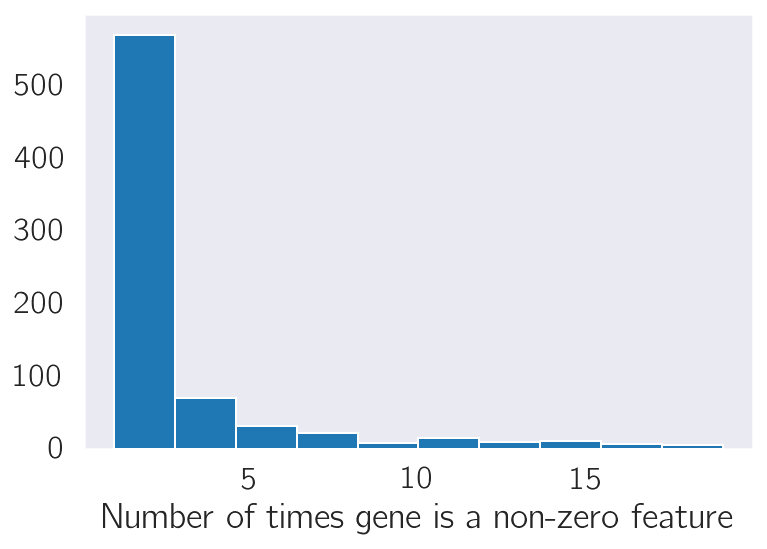

In [11]:
# test feature stability:
reps = []
genes = []  # running list of genes that have been found:
for i in np.arange(1, 50):
    clf = GradientBoostingClassifier(n_estimators=200, learning_rate=.05, subsample=0.75,
                                 max_depth=5, random_state=i, max_features='sqrt').fit(train_exp, train_labels)
    reps += [clf]
    f, miss = get_features(normed, clf.feature_importances_ > 0.005)
    f = f.external_gene_name.values
    genes += f.tolist()
    
uniq, counts = np.unique(genes, return_counts=True)
print('There are {0} selected features that appear between {1} and {2} times'.format(len(uniq), counts.min(), counts.max()))
plt.hist(counts)
_ = plt.xlabel('Number of times gene is a non-zero feature')

Let's view what the most commonly selected genes are:

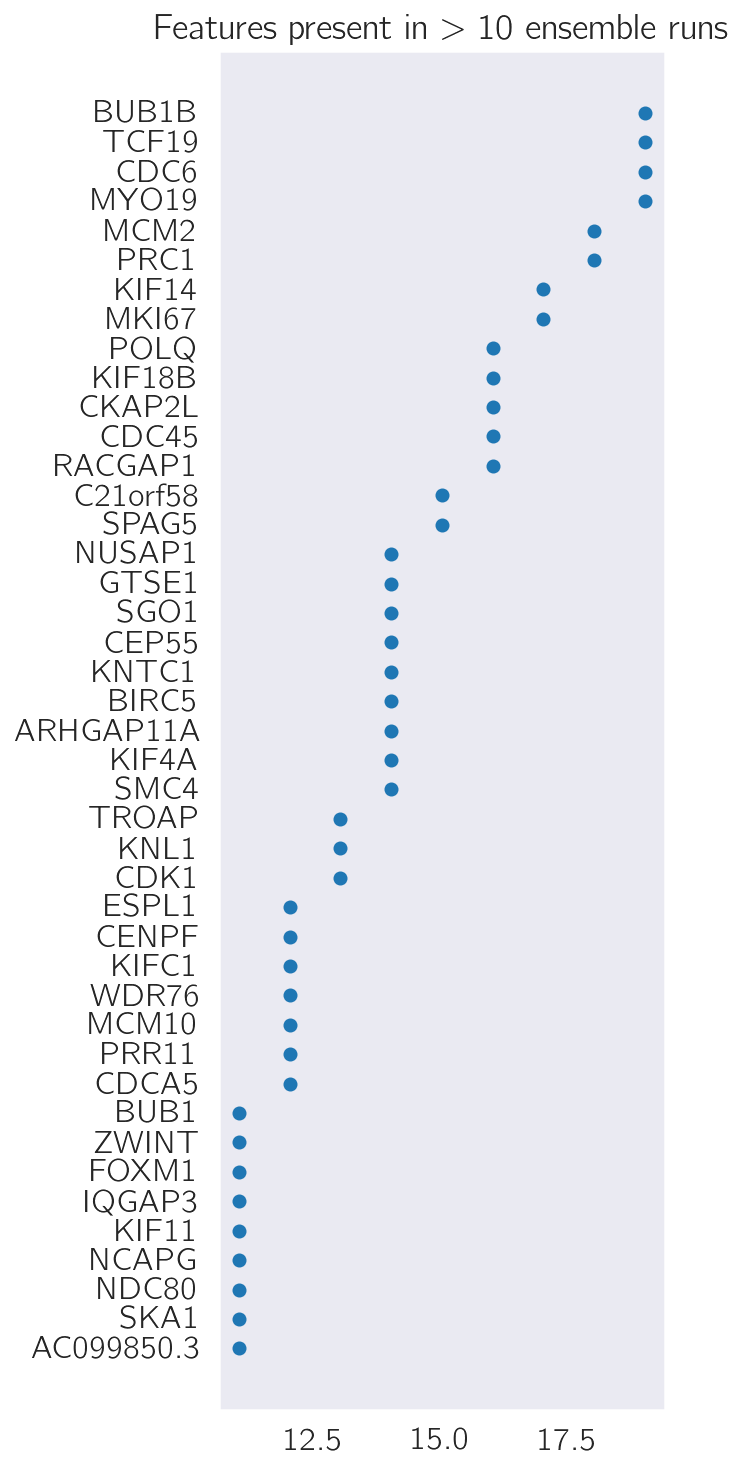

In [12]:
fig, ax = plt.subplots(figsize=(4, 12.5))
x = counts[counts > 10]
y = uniq[counts > 10]
idx = np.argsort(x)
plt.scatter(x[idx], y[idx])
_ = plt.title('Features present in $>10$ ensemble runs')

# Enrichment analysis of stable features

Let's select all genes that appeared at least 3 times in our analysis, and run an enrichment analysis on them!

In [16]:
results = sc.queries.enrich(uniq[counts > 3])
np.savetxt('../luminalAB/ensemble_genes.txt', uniq[counts > 3], delimiter=',', fmt='%s')

The results are pretty long, so let's collapse the ontology into something that makes sense.

In [14]:
def collapse(x):
    """A function to collapse similar GO terms into a small set of categories."""
    x = x.lower()
    if 'regulation of dna' in x:
        return 'dna-regulation'
    if ('mitot' in x) | ('metaphase' in x) | ('anaphase' in x) | ('cell division' in x) | ('centromere' in x):
        return 'mitosis'
    if 'meiosi' in x:
        return 'meiosis'
    if ('chromosome' in x) | ('chromosomal' in x):
        return 'chromosome'
    if ('cell cycle' in x) | ('g0' in x) | ('g1' in x) | ('g2' in x) | ('s phase' in x):
        return 'cell cycle'
    if 'cytokin' in x:
        return 'cytokinesis'
    if ('condensin' in x) | ('centrosome' in x) | ('kinetochore' in x) | ('microtubule' in x) | ('spindle' in x) | ('sister' in x):
        return 'chrom condensation'
    if 'nuclear' in x:
        return 'nuclear'
    if 'testis' in x:
        return 'testis'
    if 'supramolecular' in x:
        return 'supramolecular'
    if 'e2f; motif' in x:
        return 'e2f motif'
    if 'e2f-1' in x:
        return 'e2f-1 motif'
    if 'nf-ya; motif' in x:
        return 'nf-ya motif'
    if 'factor' in x:
        return 'factor motif, varied'
    if ('dna' in x) | ('double-strand' in x):
        return 'dna damage, integrity, packaging, repair or replication'
    if ('abnormal' in x) | ('deviation' in x) | ('head' in x) | ('forehead' in x) | ('clinodactyly' in x):
        return 'morphological abnormality, varied'
    if ('breast' in x):
        return "BREAST-" + x
    if ('cancer' in x):
        return 'cancer'
    if ('mhc class ii' in x):
        return 'mch class ii'
    
    else:
        return x
    
trimmed, trim_counts = np.unique([collapse(name) for name in results.name], return_counts=True)

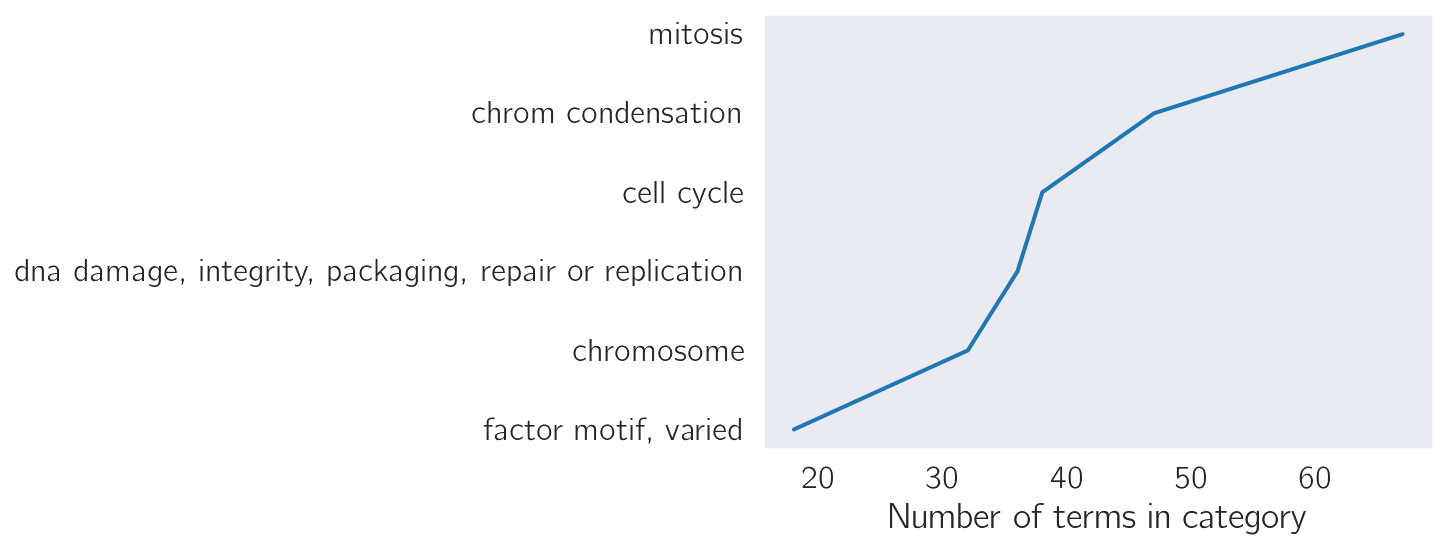

In [15]:
x = trim_counts[trim_counts > 15]
y = trimmed[trim_counts > 15]
idx = np.argsort(x)
if len(x) < 50:
    plt.plot(x[idx], y[idx])
else:
    print('too many')
_ = plt.xlabel('Number of terms in category')

It appears that the terms that are enriched most often are associated with mitosis, cell division and DNA repair. Same as with the logistic regression!